# California Housing Price Project

## Table of Contents

- [Data](#data)
    - [Tweaks](#tweaks)
- [Framing the Problem](#framing-the-problem)
- [Performance Measure](#performance-measure)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Variable or Feature Definition](#variable-or-feature-definition)
    - [Data Type](#data-type)
    - [Descriptive Statistics](#descriptive-statistics)
    - [Visualization](#visualization)
    - [Data Profiling](#data-profiling) 
- [Training Set](#training-set)
    - [Random Sampling](#random-sampling)
    - [Scikit-Learn Approach](#scikit-learn-approach)
    - [Shuffle and Split](#shuffle-and-split)
    - [Stratified K-Fold](#stratified-k-fold)
    - [Stratified Shuffle Split](#stratified-shuffle-split)
    - [Results](#results)
- [Ocean Proximity](#ocean-proximity)
- [Data Wrangling](#data-wrangling)
    - [Missing Values](#missing-values)
        - [Option 1 Remove rows](#option-1)
        - [Option 2 Drop Variable Containing Missing Values](#option-2)
        - [Option 3 Imputation](#option-3)
        - [Scikit-Learn Approach](#scikit-learn-approach)
    - [Categorical Variable](#categorical-variable)
    - [Data Transformation](#data-transformation)
    - [Custom Transformer](#custom-transformer)
    - [Tranformation Pipeline](#transformation-pipeline)
- [Model](#model)
    - [Multiple Linear Regression](#multiple-linear-regression)
    - [Decision Trees](#decision-trees)
    - [Random Forest](#random-forest)
    - [Support Vector Machine](#support-vector-machine)
    - [Model Tuning](#model-tuning)
        - [Exhaustive Grid Search](#exhaustive-grid-search)
        - [Randomized Grid Search](#randomized-grid-search)
    - [Best Models Evaluation](#best-models-evaluation)
 - [Pycaret](#pycaret)
    


## Data <a class="anchor" id="data"></a>

The dataset used in this project is the California Housing Prices dataset from the StatLib repository. This dataset is a modified version of the California Housing dataset available from [Luís Torgo's page](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (University of Porto). Luís Torgo obtained it from the StatLib repository (which is closed now). The dataset may also be downloaded from StatLib mirrors.

This dataset appeared in a 1997 paper titled *Sparse Spatial Autoregressions* by Pace, R. Kelley and Ronald Barry, published in the *Statistics and Probability Letters* journal. These researchers built the data set using the 1990 California census data. The dataset contains one row per census block group. A **block group** is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).




### Tweaks <a class="anchor" id="tweaks"></a>

The dataset is almost identical to the original, with two differences:

* 207 values were randomly removed from the `total_bedrooms` column, so we can discuss what to do with missing data. This data deletion is carried out for practicing purposes.

* An additional categorical attribute called `ocean_proximity` was added, indicating (very roughly) whether each block group is near the ocean, near the Bay area, inland or on an island. This allows for our discussing what to do with categorical data.

The block groups are sometimes refered to as "districts" in the Jupyter notebooks, simply because in some contexts the name "block group" is confusing. Below is the heat map of the data set:

<p align="center">
  <img width="600" height="250" img src="Images/dataset.png">
</p>



## Framing the Problem <a class="anchor" id="framing-the-problem"></a>

The goal of the project is to build a model that predicts the median housing prices of districts in California given a set of features or variables. The model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system (see the figure below), along with many other signals. A signal is a piece of information fed to a Machine Learning system; this terminology originates from Claude Shannon’s information theory. The downstream system will then determine whether it is worth investing in a given area or not. Therefore, making accurate predictions of housing prices is critical to our success as it directly affects revenue. The diagram below portrays the pipeline:

<p align="center">
  <img width="600" height="250" img src="Images/system.png">
</p>

The project can be classified as a typical supervised learning task, since we are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). In statistics terms, we have been given observed response values--- median housing prices--- for all districts and we must fit a model to the observational data. More specifically, this is a multiple regression problem, since the system will use multiple features (statistical variables) to make a prediction (it will use the district’s population, the median income, etc.). The problem is also a univariate regression problem, since we are only trying to predict a single value for each district. If we were trying to predict multiple values (joint estimation) per district, it would be a multivariate regression problem. Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so batch learning or offline learning should suffice. 



## Performance Measure <a class="anchor" id="performance-measure"></a>

The performance measure we will use is the standard deviation of the regression model--- the root mean square error (RMSE). Using machine learning notations, RMSE is given by the following formula:


$\operatorname{RMSE}(\mathbf{X}, h)=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(h\left(\mathbf{x}^{(i)}\right)-y^{(i)}\right)^{2}}$

- $n$ is the number of instances in the dataset we are measuring the RMSE on.
    - For example, if we are evaluating the RMSE on a validation set of 2,000 districts, then $n=2,000$
- $\mathbf{x}^{(i)}$ is a vector of all the feature values (predictor variables) of the $i^{\text {th}}$ instance in the dataset, and $y^{(i)}$ is its label (or the $i{\text{th}}$ observed response value).
    - For example, if the first district in the dataset is located at longitude $-118.29^{\circ}$, latitude $33.91^{\circ}$, and it has 1,416 inhabitants with a median income of $\$ 38,372$, and the median house value is $\$ 156,400$ (ignoring the other features for now), then:
$$
\mathbf{x}^{(1)}=\left(\begin{array}{c}
-118.29 \\
33.91 \\
1,416 \\
38,372
\end{array}\right)
$$
and:
$$
y^{(1)}=156,400
$$
- $\mathbf{X}$ is a matrix containing all the feature values (less the column of 1's) of all $n$ instances in the dataset. There is one row per instance, and the $i^{\text {th}}$ row is equal to the transpose of $\mathbf{x}^{(i)}$, noted $\left(\mathbf{x}^{(i)}\right)^{\mathrm{T}}$. This is slightly different from the **design matrix** commonly used in statistics.
    - For example, if the first district is as just described, then the matrix $\mathbf{X}$ looks like this:
$$
\mathbf{X}=\left(\begin{array}{c}
\left(\mathbf{x}^{(1)}\right)^{\top} \\
\left(\mathbf{x}^{(2)}\right)^{\top} \\
\vdots \\
\left(\mathbf{x}^{(1999)}\right)^{\top} \\
\left(\mathbf{x}^{(2000)}\right)^{\top}
\end{array}\right)=\left(\begin{array}{cccc}
-118.29 & 33.91 & 1,416 & 38,372 \\
\vdots & \vdots & \vdots & \vdots
\end{array}\right)
$$
- $h$ is our system's prediction function, also called a **hypothesis**. A hypothesis is a candidate model that approximates a target function for mapping inputs to outputs. When our system is given an instance's feature vector $\mathbf{x}^{(i)}$, it outputs a predicted value $\hat{y}^{(i)}=h\left(\mathbf{x}^{(i)}\right)$ for that instance $(\hat{y}$ is pronounced "y-hat"). In statistics terminologies, the hypothesis is sort of like the candidate regression model, $Y=\mathbf{X}\beta+\varepsilon$.
    - For example, if our system predicts that the median housing price in the first district is $\$ 158,400$, then $\hat{y}^{(1)}=$ $h\left(\mathbf{x}^{(1)}\right)=158,400$. The prediction error (residual) for this district is $\hat{y}^{(1)}-y^{(1)}=158,400 - 156,400=2,000$
- Lastly, $\operatorname{RMSE}(\mathbf{X}, h)$ is the cost function measured on the set of examples using our hypothesis $h$.


## Exploratory Data Analysis <a class="anchor" id="exploratory-data-analysis"></a>

We begin by downloading the dataset from [Aurelien Geron](https://www.linkedin.com/in/aurelien-geron/?originalSubdomain=nz)'s github repository:

In [3]:
# Library and modules
import os
import tarfile
import urllib.request
# Current working directory
os.getcwd()
# Change working directory
# We want the dataset to be stored in the root directory 
os.chdir(os.getcwd().replace("/jupyter_notebooks", ""))


# Download root
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# Path to Geron's github directories
# Concatenate strings using "/" to create url
housing_url = os.path.join(download_root, "datasets", "housing", "housing.tgz")
# Path to store file on local machine
housing_path = "dataset"


# Function for fetching data
def fetch_housing_data(housing_url=housing_url, housing_path=housing_path):
    # If the subdirectory 'dataset' does not already exist, create it
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    # Path for tar archive, producing the string 'dataset/housing.tgz'
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # Retrieve form url the tar archive file and store it in the path created above
    urllib.request.urlretrieve(housing_url, tgz_path)
    # Open tar archive for reading, writing or appending 
    housing_tgz = tarfile.open(tgz_path)
    # Extract all members from the archive to directory path
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
# Call the function
fetch_housing_data()

Next, we define a function that imports the .csv file:

In [4]:
# Package
import pandas as pd
# Function 
def read_housing_csv(path=housing_path):
    return pd.read_csv(
        os.path.join(housing_path, "housing.csv"),
        header="infer",
        index_col=None
    )
# Load data
housing = read_housing_csv()

### Variable or Feature Definitition <a class="anchor" id="variable-or-feature-definition"></a>

The variable definitions can be summarized as follows:

Variable (Feature) |Definition |
-----|-----|
Longitude|A measure of how far west a house is; a higher value is farther west|
Latitude|A measure of how far north a house is; a higher value is farther north|
HousingMedianAge|Median age of a house within a block; a lower number indicates a newer building|
TotalRooms|Total number of rooms within a block|
TotalBedrooms|Total number of rooms within a block|
Population|Total number of people residing within a block|
Households|Total number of households, a group of people residing within a home unit, within a block|
MedianIncome|Median income for households within a block of houses (measured in tens of thousands of US Dollars)|
MedianHouseValue|Median house value for households within a block (measured in US Dollars)|
OceanProximity|Categorical location of housing units w.r.t the ocean|

### Data Type <a class="anchor" id="data-type"></a>

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


&nbsp;

All variables or features are continuous or numerical (double/float64 date type) except for "ocean_proximity," which is discrete or categorical (text object data type). The sample size is $n=20640$ and all but one variable--- total_bedrooms--- are non-missing.

### Descriptive Statistics <a class="anchor" id="descriptive-statistics"></a>

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


From the descriptive statistics table, we see that the distribution of the response variable or the label--- median housing value--- is positively skewed or right-skewed, since the mean value is greater than the median value. Other continuous features or predictor variables--- district population, district households, district median income--- are also right-skewed. Therefore, we may need to transform a few of the variables depending on the results of our diagnostics.  

### Visualization <a class="anchor" id="visualization"></a>

It may also be helpful to visualize the univariate distributions of the predictor variables or features. Below, we will create univariate histograms, box and whisker plots, and an overall scatterplot matrix. However, before any visualization, we must define a function to save our figures:

In [5]:
# Funtion to save plots
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir("visualization"):
        os.makedirs("visualization")
    path = os.path.join("visualization", fig_id + "." + fig_extension)
    # User-facing progress report
    print("Saving figure", fig_id)
    # The function tight_layout() automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Next, we create the univariate histograms. Note that the first line `%matplotlib inline` ensures that the IPython kernel uses an alternative backend when performing the necessary behind-the-scenes setup to work with `matplotlib`. With this backend, the output of plotting commands is displayed inline within this Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document. 

Saving figure attribute_histogram_plots


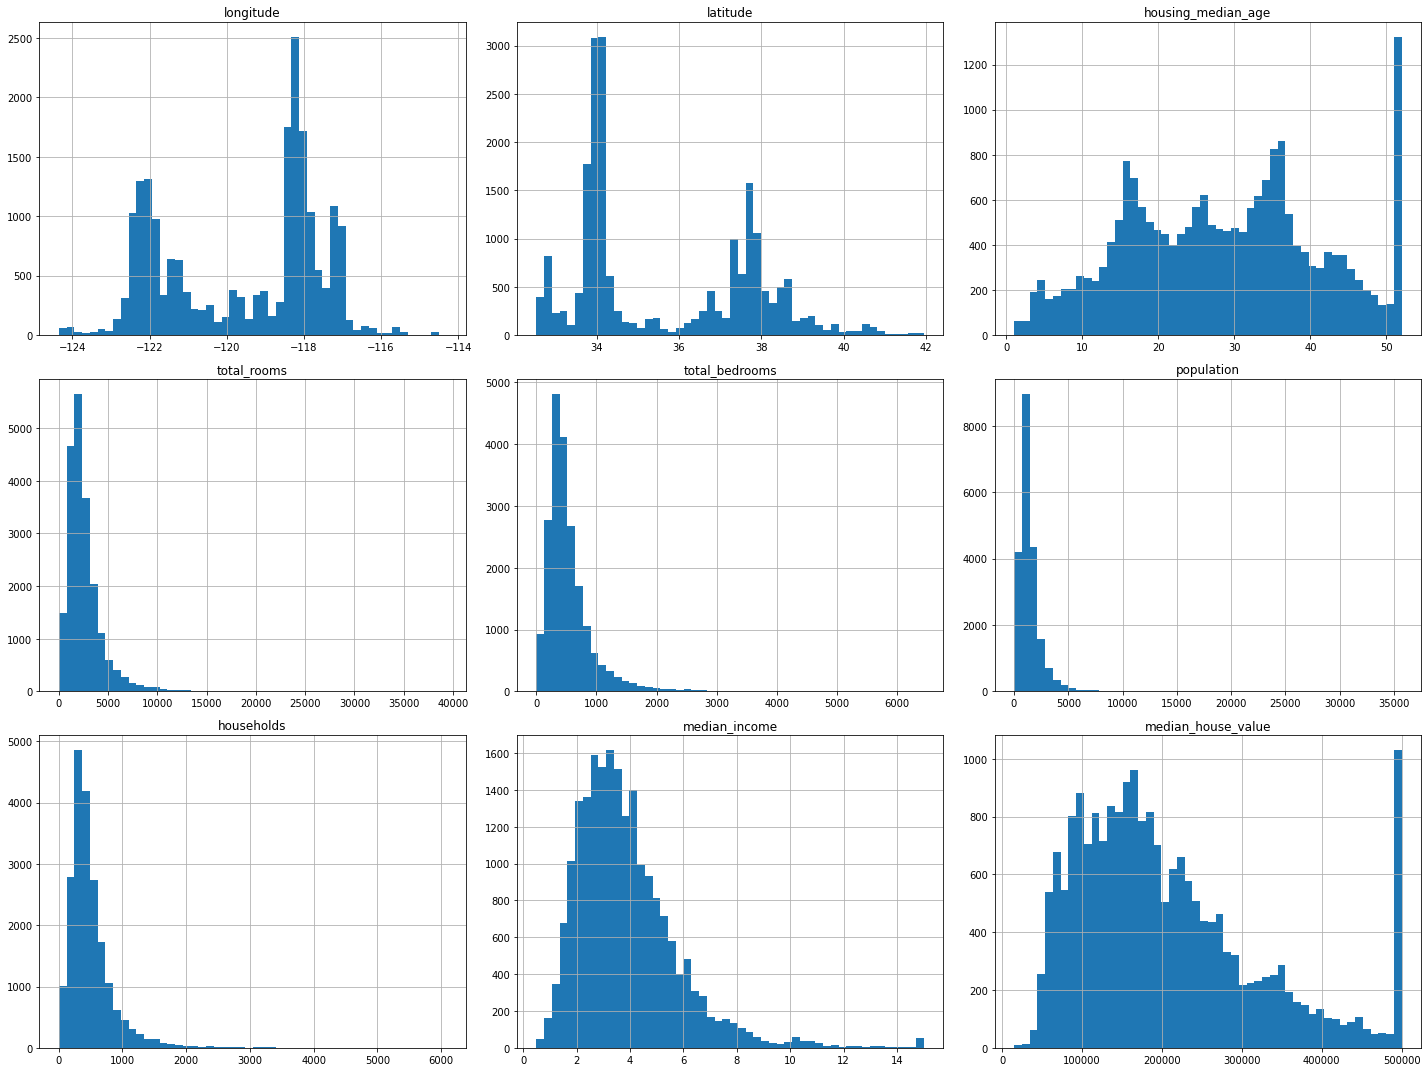

In [6]:
# Magic function
%matplotlib inline
# Import module and parameters
import matplotlib.pyplot as plt
# Hitograms
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

The visualizations confirm our findings from the descriptive statistics that many of the the univariate distributions are right-skewed. Since the multiple linear regression model assumes that the $Y_{i}$ are independent normal random variables given the combinations of predictor variables, some transformations may be required to handle non-normality. Futher, two variables--- median housing value and median housing age--- are capped. The former may be a serious problem since it is our target attribute, which are the labels. Our machine learning algorithms may learn that prices never go beyond those limits. If there is a need for precise predictions even beyond the capped value $\$500,000$, then we have two options:

* Collect proper labels for the districts whose labels were capped.

* Remove those districts from the training set (and also from the test set, since our system should not be evaluated poorly if it predicts values beyond $500,000). 

Next, we plot the boxplot and whisker plots:


Saving figure attribute_box_whisker_plots


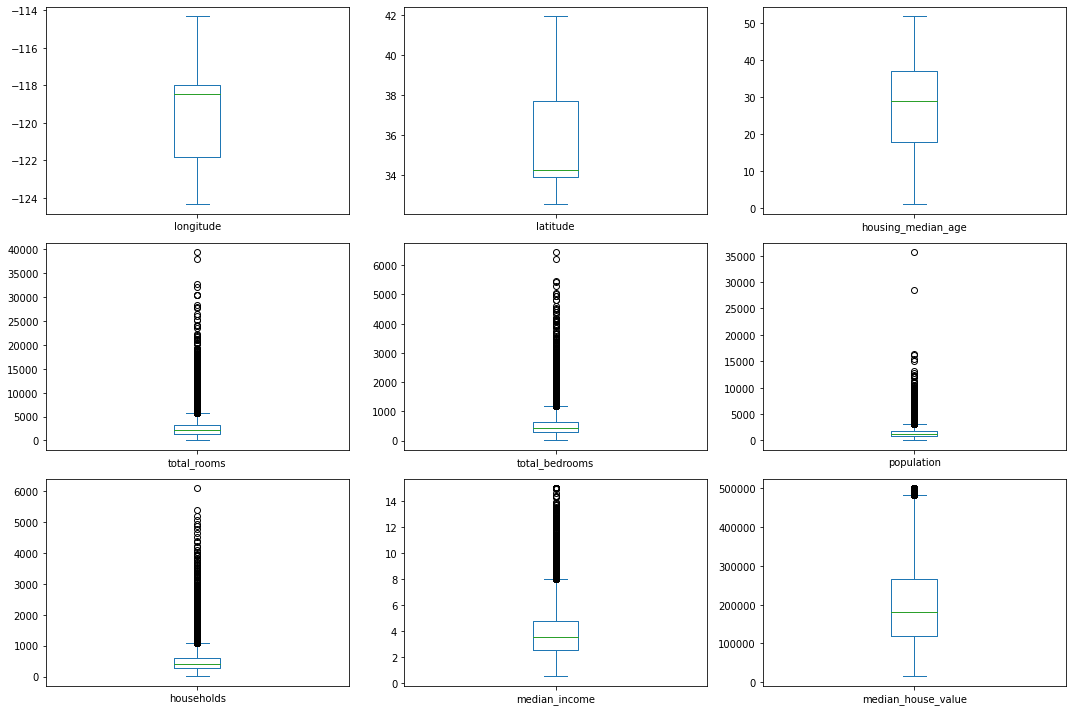

In [10]:
# Figure size
plt.rcParams['figure.figsize'] = [15, 10]
# Box and whisker plots
# Each subplot x- or y-axis will be independent using x (sharex) or y (sharey) axes = False
housing.plot(kind='box', subplots=True, layout=(3, 3), sharex=False, sharey=False)
save_fig("attribute_box_whisker_plots")
plt.show()

Evidently, the usual suspects such as population, households, and median income have many outlaying values that lie beyond $\text{Q3} + 1.5\times(\text{Q3}-\text{Q1})$. Lastly, we construct the scatterplot matrix for this data set:

Saving figure attribute_scatterplot_matrix


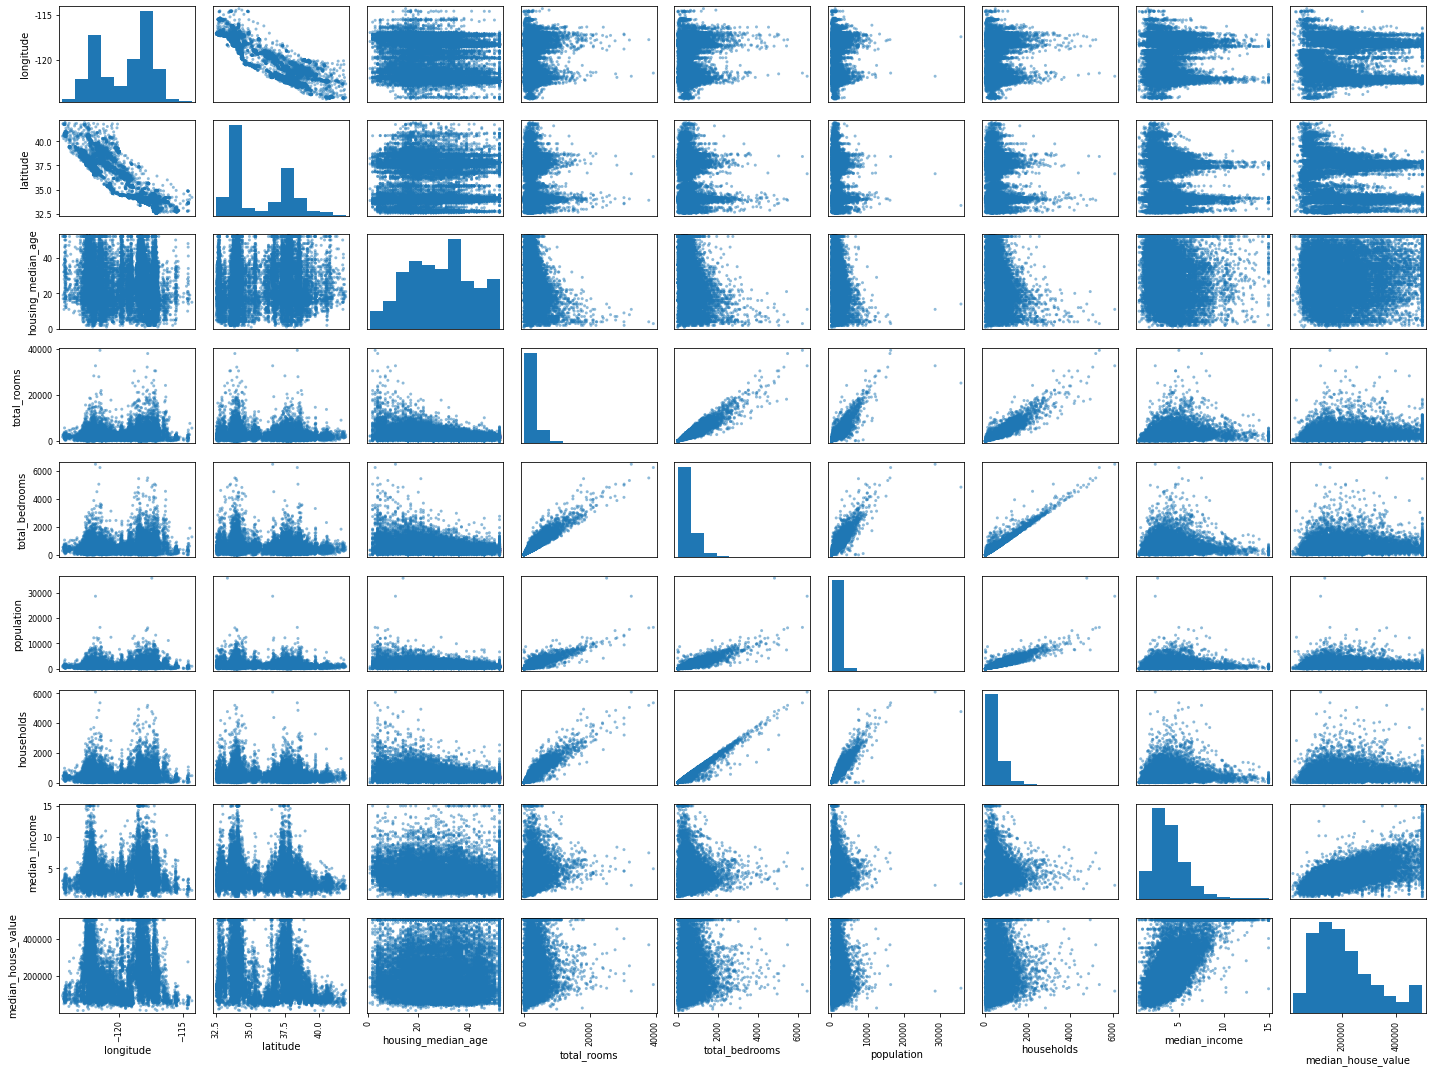

In [11]:
# Size
plt.rcParams['figure.figsize'] = [20, 15]
# Import module
from pandas.plotting import scatter_matrix
# Scatterplot matrix
scatter_matrix(housing)
save_fig("attribute_scatterplot_matrix")
plt.show()

Theses scatter plots of the response variable against each predictor variable can aid in determining the nature and strength of the  bivariate relationships between each predictor and the response. Focusing on the last row of the matrix, we have the following findings:

* It is hard to say that the response variable has any linear or non-linear relationship with housing median age. 

* The relationship between the response and population appears to be almost **undefined** or **infinite sloped** as the nature of the relationship appears nearly vertical. Vertical lines are problematic in that there is little change in the predictor variable.     

* The response variable appears to show weak positive statistical relation with total rooms, total bedrooms, households; it appears to have a relatively strong positive statistical relation with median income.

* We may have some multicolinearity issues since many of the predictor variables are strongly correlated ($r_{\text{Pearson}}>0.8$) with one another. This can be demonstrated using a correlation matrix below

In [22]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


### Data Profiling <a class="anchor" id="data-profiling"></a>

Finally, we could, in fact, automate all of the above using the profiling functionality of `pandas`. Below, we generate a profile reports from the pandas DataFrame that automatically conducts exploratory data anaylsis (EDA).   

In [13]:
# Import module
from pandas_profiling import profile_report
# Generate profile report
housing.profile_report().to_file("dataset/profile_report_full.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Training Set <a class="anchor" id="training-set"></a>

Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The **validation set approach** is a very simple strategy for this task. It involves randomly or strategically dividing the available set of observations into two parts, a **training set** and a **validation set** or **test** or **hold-out** set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation or **test set**. The resulting validation set error rate— typically assessed using MSE or RMSE in the case of a quantitative response— provides an estimate of the test error rate. 

### Random Sampling <a class="anchor" id="random-sampling"></a>

To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, we could compute a **hash** of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. 

> We want to solve the problem of comparing strings efficiently. The brute force way of doing so is just to compare the letters of both strings, which has a time complexity of O(min(n1,n2)) if n1 and n2 are the sizes of the two strings. We want to do better. The idea behind strings is the following: we convert each string into an integer and compare those instead of the strings. In this way, comparing two strings becomes an O(1) operation. For the conversion, we need a so-called hash function. The goal of it is to convert a string into an integer, the so-called **hash** of the string.

This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset. When we add new instances to the dataset, the new test set will contain $20\%$ of these new instances; it will not contain any instance that was previously in the training set.

In [11]:
# Import function
from zlib import crc32
import numpy as np
# Test if hash is lower than or equal to 20% of the maximum hash values, which is 2^32
def test_set_check(identifier, test_ratio):
    # The function int64() converts dtype to numpy.int64
    # The function crc32() returns the unsigned 32-bit checksum integer for the given data
    # The 0xffffffff is a hexadecimal integer constant with value 4294967295
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
# Split train test by an id column
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    # Each id_ is an identifier value in the column data[id_column]
    # If test_set_check() returns True, those id_ are allocated to the test set
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    # Return rows whose id_'s are not in the test set and those whose id_'s are in the test set 
    # First training set (not in test set) then test set
    return data.loc[~in_test_set], data.loc[in_test_set]

Since the housing dataset does not have an identifier column, we could use the row index of the `DataFrame` object as the identifier by passing 'index'. Internally, this obtains the `index` series:

In [12]:
# Add index column
housing_with_id = housing.reset_index() 
# First training then test set
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Using the row index as a unique identifier means we must make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. Let us examine the resulting sets:

In [12]:
# Test set should be ~20% of full datasets
round(len(test_set) / len(housing), 10)

0.2

### Scikit-Learn Approach <a class="anchor" id="scikit-learn-approach"></a>

`Scikit-Learn` provides a few functions to split datasets into multiple subsets in various ways. The simplest function is similar to our custom `split_train_test_by_id()` function:

In [13]:
# Import helper function
from sklearn.model_selection import train_test_split
# Split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=7)
# Check
round(len(test_set) / len(housing), 10)

0.2

The random sampling methods may be efficient. However, in our project, the median income variable is a very important attribute to predict median housing prices; therefore, we may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, we first need to create an income category attribute--- a factor so to speak. 

In [14]:
# Create a factor
housing["income_cat"] = pd.cut(
    # Input to be binned (arbitrarily selected)
    x=housing["median_income"],
    # Sequence of scalars for bin edges
    bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
    # Bin lables for each returned bins
    labels=[1, 2, 3, 4, 5]
)
# Get porportions 
housing.income_cat.value_counts() / len(housing.income_cat)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

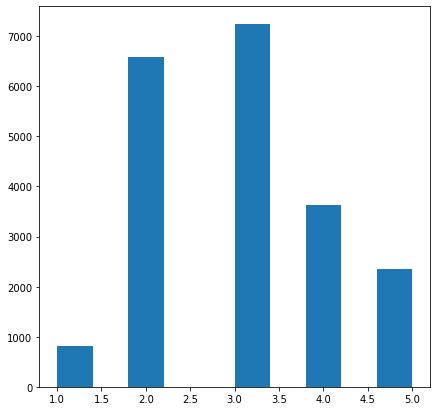

In [16]:
# Import module and parameters
import matplotlib.pyplot as plt
# Figure size
plt.rcParams['figure.figsize'] = [7, 7]
# Hisgrogram 
housing.income_cat.hist()
plt.grid(False)
plt.show()

Now, we may use stratified sampling to split our full dataset based on the income categorical variable. Specifically, we use the `StratifiedShuffleSplit` spitter class from the `sklearn.model_selection` module. This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each of the five income classes:

In [17]:
# Import class
from sklearn.model_selection import StratifiedShuffleSplit
# Cross-validator object of class StratifiedShuffleSplit 
cv_object = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
# Use the split() method for the StratifiedShuffleSplit class
# This method generates indices to split data into training and test set
for train_index, test_index in cv_object.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

### Shuffle and Split <a class="anchor" id="shuffle-and-split"></a>

To better understand the sampling technique and the `scikit-learn` implementation above, we need to visualize the behaviors of the two aforementioned techniques. Suppose we wish to carry out three iterations of re-shuffling and splitting; in other words, we specify `n_splits=3`. The `ShuffleSplit` iterator will generate a user defined number of independent train/test dataset splits. Samples are first shuffled to ensure that no neighboring rows from the original data sets are selected; then, the shuffled rows are split into pairs of train and test sets. Specifying `n_splits=3` ensures that we have three independent sets of $(0.2, 0.8)$ splits. We may visualize the behavior as follows:

<p align="center">
  <img width="450" height="200" img src="Images/shuffle_split.png">
</p>

Note that `ShuffleSplit` is not affected by classes or groups. The orange strips (test set) are selected without regards to classes and it is possible for some classes to have no values selected for the test set during any given interation. For example, in the third iteration above, no observations/instances from the light blue class were selected for the test set. This ultimately means the `ShuffleSplit` iterator does not preserve the class proportions observed in the full dataset.

### Stratified K-Fold <a class="anchor" id="stratified-k-fold"></a>

Some classification problems can exhibit a large imbalance in the distribution of the target classes. In our exampe, due to the skewness of the distribution of the median income attribute, there are more observations in some income categories than others. Therefore, purely random sampling would introduce some sampling bias into our train/test split. In such cases it is recommended to use **stratified sampling** as implemented in `StratifiedKFold` and `StratifiedShuffleSplit` to ensure that relative class proportions is approximately preserved in each train and test fold. The class `StratifiedKFold` is a variation of k-fold which returns stratified folds--- each set contains approximately the same percentage of samples of each target class as the complete set. 

<p align="center">
  <img width="450" height="200" img src="Images/stratified_kfold.png">
</p>

As can be seen, during each iteration, the class proportions are approximately preserved. However, there is no shuffling in this implementation and so it is possible for blocks of neighboring rows to be selected to the test set toghether.     

### Stratified Shuffle Split <a class="anchor" id="stratified-shuffle-split"></a>

Finally, the `StratifiedShuffleSplit` merges the two aforementioned techniques. As mentioned earlier, this cross-validation technique returns stratified randomized folds. Below is a visualization of the cross-validation behavior:

<p align="center">
  <img width="450" height="200" img src="Images/stratified_shuffle_split.png">
</p>

In our implementation above, the `StratifiedShuffleSplit` constructor creates one set of randomized $(0.2, 0.8)$ fold, because we specified `n_splits=1`. Next, we call the `split(X, y, groups=None)` method on the `StratifiedShuffleSplit` class, which returns a generator. A generator is a function that returns an object (an iterator) which we can iterate over (one value at a time). We can check the data type using `is.isgenerator(cv_object.split(housing, housing["income_cat"]))`. The arguments for the `split()` function are `X` and `y`, since `group` exists only for compatibility. The argument `X` is the full dataset. The arguemnt `y` is the classification variable; stratification is done based on the `y` labels. The generator is then passed as the iterable of the for loop. During each iteration of the for loop, a `train_index` ndarray and a `test_index` ndarray yielded by the generator are used to extract rows from the data frame; these rows are then assigned to their respective sets--- `strat_train_set` and `strat_test_set`. Examine the porportions of the training set and the test set:

In [18]:
strat_train_set.income_cat.value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [19]:
strat_test_set.income_cat.value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Evidently, the proportions of observations that fall into each income category are well in preserved both sets. 

### Results <a class="anchor" id="results"></a>

We may also tabulate the proportions of the training and test sets as well as those of the full datasets for better comparisons:  

In [20]:
# Define a function that computes the sample proportions
def prop(data):
    return data.income_cat.value_counts() / len(data)


# Create a data frame
prop_table = (
    pd.DataFrame({
        "Full Data Set": prop(data=housing),
        "Training Set": prop(data=strat_train_set),
        "Test Set": prop(data=strat_test_set), 
    })
    .sort_index()
)
# Add error rates using percentage change formula
prop_table["Training set Error Rate %"] = (prop_table["Training Set"] / prop_table["Full Data Set"] - 1) * 100
prop_table["Test set Error Rate %"] = (prop_table["Test Set"] / prop_table["Full Data Set"] - 1) * 100
# Display table
prop_table

,Full Data Set,Training Set,Test Set,Training set Error Rate %,Test set Error Rate %
1,0.039826,0.039789,0.039971,-0.091241,0.364964
2,0.318847,0.318859,0.318798,0.003799,-0.015195
3,0.350581,0.350594,0.350533,0.003455,-0.013820
4,0.176308,0.176296,0.176357,-0.006870,0.027480
5,0.114438,0.114462,0.114341,0.021169,-0.084674


The values in the table above indicates that the error rates are extremely small and we can be confident that the class proportions are preserved. We may proceed to remove the `income_cat` variable from the dataset. The iterable of the loop context is a tuple: 

In [21]:
# Remove columns from training and test sets
for data_set in (strat_train_set, strat_test_set):
    data_set.drop("income_cat", axis=1, inplace=True)

Let us ensure that the variable is indeed removed from the training and test sets:

In [22]:
for data_set in (strat_train_set, strat_test_set):
    print("income_cat" in data_set.columns)

False
False


## Ocean Proximity <a class="anchor" id="ocean-proximity"></a>

One of the most important factors that affect housing value is amenity. In real estate, amenity is something considered to benefit a location, contribute to its enjoyment, and thereby increasing its value. In the originial dataset, the only geospatial attributes or variables are the coordinates of the housing units. No other geospatial features of the housing units are proxied for in the study. This will likely lead to omitted vairable bias if the location of the housing units are correlated with the their values and even other predictor variables. In fact, this has been a common knowledge to almost all who are involved in land planning and real estate. In our case, one of the factors that may impact the value of a particular housing unit is its proximity to the ocean, which is a relevant amenity that buyers and investors must adequately assess in coastal California. We can create a plot to further visualize this pattern in the dataset:    

Saving figure housing_prices_scatterplot


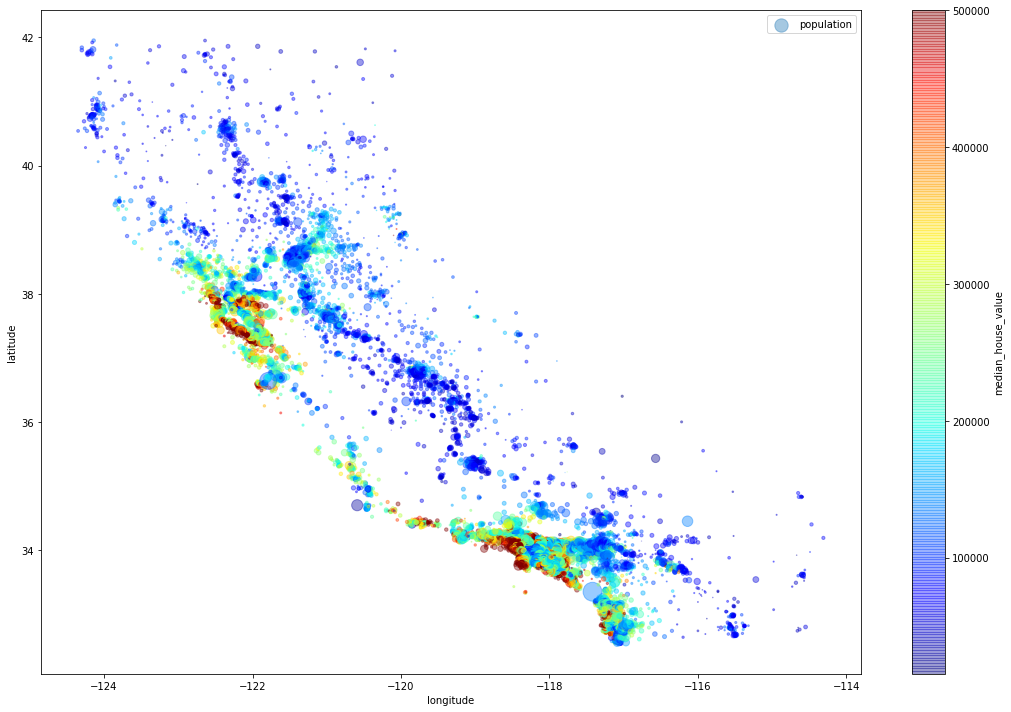

In [23]:
# Scatter plot with heat map
housing.plot(
    kind="scatter", 
    x="longitude", y="latitude", alpha=0.4,
    sharex=False,
    figsize=(15, 10),
    # Marker size
    s=housing["population"] / 100, 
    label="population", 
    # Marker color
    c="median_house_value", 
    # Choose color map
    cmap=plt.get_cmap("jet"), 
    colorbar=True
)
save_fig("housing_prices_scatterplot")

The `plot()` method called on the pandas data frame uses `matplotlib.pyplot.scatter` as its backend. As can be seen, the median housing values are higher for the units that are closer to the ocean. The ocean proximity attribute may certainly be useful, although in Northern California the housing prices in coastal districts are not too high, so there may be other important factors that determine housing value.  

## Data Processing Pipeline <a class="anchor" id="data-wrangling"></a>

The first step is to create a copy of the training set. We also separate the predictors and the labels (response), since we don’t necessarily want to apply the same transformations to the predictors and the target values: 

In [67]:
# Drop response or label values
housing_features = strat_train_set.drop(
    labels=["median_house_value"], 
    axis=1,
    inplace=False
) 
# Store the response or label values
# The name 'housing_labels' references a copy of the label series
housing_labels = strat_train_set["median_house_value"].copy()

### Missing Values <a class="anchor" id="missing-values"></a>

There are three options to deal with missing values in the `total_bedrooms` variable:

* Get rid of the corresponding districts (remove rows)
* Get rid of the whole attribute (remove variables)
* Set the values to some value (imputation with zero, the mean, the median, etc.)

We can demonstrate all three options on a copy of our data frame, including only those rows where the `total_bedrooms` variable has a missing value:

In [23]:
# Returns a series of True's and False's with original row indices
# True's mean that the row contains missing values
housing_features.isna().any(axis=1)

8088     False
15259    False
710      False
12828    False
18294    False
         ...  
8285     False
20569    False
12632    False
5135     False
2786     False
Length: 16512, dtype: bool

In [24]:
# Ramdomly select five rows with missing values
sample_incomplete_rows = housing[housing.isna().any(axis=1)].sample(n=5)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15397,-117.20,33.24,12.0,4992.0,NaN,2106.0,801.0,6.2079,<1H OCEAN
14386,-117.23,32.75,5.0,1824.0,NaN,892.0,426.0,3.4286,NEAR OCEAN
18261,-122.08,37.37,29.0,1229.0,NaN,707.0,194.0,7.1108,NEAR BAY
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND
13311,-117.61,34.08,12.0,4427.0,NaN,2400.0,843.0,4.7147,INLAND


### Option 1: Remove rows  <a class="anchor" id="option-1"></a>

The first option is to remove all instances or observations that contain missing values for one or more of the variables. This is perhaps the simplest but least sound approach, since, in many cases, data are not missing at random (MAR). Deletion of data will evidently introduce bias into our results.  

In [25]:
sample_incomplete_rows.dropna(
    # Drop rows which contain missing values
    axis=0,
    # Determine if row or column is removed from DataFrame, when we have at least one NA or all NA
    how="any",
    # Define in which column(s) to look for missing values
    subset=["total_bedrooms"],
    inplace=False
)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


### Option 2: Drop Variable Containing Missing Values <a class="anchor" id="option-2"></a>

The next option is a relatively safer approach; we remove the variable(s) containing missing values from consideration when fitting the model or training the algorithm. This approach ensures that we at least maintain all instances or observations in a training set. 

In [26]:
sample_incomplete_rows.drop(
    labels=["total_bedrooms"],
    # Columns rather than rows
    axis=1,
    inplace=False
)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
15397,-117.20,33.24,12.0,4992.0,2106.0,801.0,6.2079,<1H OCEAN
14386,-117.23,32.75,5.0,1824.0,892.0,426.0,3.4286,NEAR OCEAN
18261,-122.08,37.37,29.0,1229.0,707.0,194.0,7.1108,NEAR BAY
6052,-117.76,34.04,34.0,1914.0,1564.0,328.0,2.8347,INLAND
13311,-117.61,34.08,12.0,4427.0,2400.0,843.0,4.7147,INLAND


### Option 3: Imputation <a class="anchor" id="option-3"></a>

The final option is imputation, which is the process of replacing missing data with substituted values. Since the variable `total_bedrooms` is highly right-skewed, we will use the median rather than the mean as the replacement values. 

In [27]:
# Median value
median = housing.total_bedrooms.median()
# Call fillna() function
sample_incomplete_rows.total_bedrooms.fillna(
    value=median,
    inplace=True
)
# Examine
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15397,-117.20,33.24,12.0,4992.0,435.0,2106.0,801.0,6.2079,<1H OCEAN
14386,-117.23,32.75,5.0,1824.0,435.0,892.0,426.0,3.4286,NEAR OCEAN
18261,-122.08,37.37,29.0,1229.0,435.0,707.0,194.0,7.1108,NEAR BAY
6052,-117.76,34.04,34.0,1914.0,435.0,1564.0,328.0,2.8347,INLAND
13311,-117.61,34.08,12.0,4427.0,435.0,2400.0,843.0,4.7147,INLAND


### Scikit-Learn Approach <a class="anchor" id="scikit-learn-approach"></a>

`Scikit-Learn` provides a handy class to handle missing values--- `SimpleImputer`. First, we need to create an
instance, specifying that we wish to replace each attribute’s missing values with the median of that attribute.

In [23]:
# Import class from the impute module
from sklearn.impute import SimpleImputer
# Instantiate an imputer object
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy="median",
    copy=True,
    add_indicator=False
)

Since the median can only be computed on numerical attributes, we create a copy of the data without the text attribute `ocean_proximity`:

In [24]:
# Drop column
housing_numerical_features = housing.drop(
    labels=["ocean_proximity"],
    axis=1,
    inplace=False
)               
# Examine
housing_numerical_features.head(n=5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


In [30]:
# Alternatively
housing_numerical__features_2 = housing_features.select_dtypes(include=np.number)            
# Examine
housing_numerical__features_2.head(n=5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229


Next, we call the `fit()` method on the imputer object:

In [31]:
# Fit the imputer on X
imputer.fit(X=housing_numerical_features)
# Examine computed statistics
imputer.statistics_.round(decimals=4)

array([-118.5   ,   34.26  ,   29.    , 2125.    ,  435.    , 1166.5   ,
        409.    ,    3.5372])

This should be equivalent to computing the column medians manually:

In [32]:
housing_numerical_features.median().values.round(decimals=4)

array([-118.5   ,   34.26  ,   29.    , 2125.    ,  435.    , 1166.5   ,
        409.    ,    3.5372])

Now we can use this “trained” `imputer` to transform the training set by replacing missing values with the learned medians:

In [33]:
X = imputer.transform(X=housing_numerical_features)

The returned value is a `numpy` array containing `nrow` sets of feature values:

In [34]:
# Number of elements is the number of rows in the training set 
len(X)

16512

In [35]:
# Each element is in and of itself an array containing 8 values, one for each predictor variable
X[0:2]

array([[-118.21  ,   33.82  ,   34.    , 1719.    ,  398.    , 1444.    ,
         372.    ,    2.8438],
       [-117.27  ,   33.03  ,   25.    , 1787.    ,  311.    , 1108.    ,
         311.    ,    3.9826]])

To obtain the training set, we convert the `array` object to a pandas `DataFrame`:

In [36]:
housing_tr = pd.DataFrame(
    data=X, 
    # Use extracted column attributes
    columns=housing_numerical_features.columns,
    # Use indices of the training set
    index=housing_features.index
)

Let us have a sanity check to see if the missing values have been tranformed:

In [37]:
# Subset those row originally with missing values
# The index array is taken from the examples above
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15397,-117.20,33.24,12.0,4992.0,435.0,2106.0,801.0,6.2079
14386,-117.23,32.75,5.0,1824.0,435.0,892.0,426.0,3.4286
18261,-122.08,37.37,29.0,1229.0,435.0,707.0,194.0,7.1108
6052,-117.76,34.04,34.0,1914.0,435.0,1564.0,328.0,2.8347
13311,-117.61,34.08,12.0,4427.0,435.0,2400.0,843.0,4.7147


As can be seen, the missing values in the `total_bedrooms` column have been imputed using its median in the *training set*. The imputer thus provides us with an easy method to replace missing values with a sample statistic. The calculation of such statistic is carred out by the `fit()` method. Then, the `transform()` method replaces the missing values, and thereby *transforming* the data. The `fit_transform()` method will undertake both steps internally: 

In [38]:
# One step
X = imputer.fit_transform(
    X=housing_numerical_features
)
# Convert to data frame
housing_tr_2 = pd.DataFrame(
    data=X, 
    # Use extracted column attributes
    columns=housing_numerical_features.columns,
    # Use indices of the training set
    index=housing.index
)
# Examine
housing_tr_2.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15397,-117.20,33.24,12.0,4992.0,435.0,2106.0,801.0,6.2079
14386,-117.23,32.75,5.0,1824.0,435.0,892.0,426.0,3.4286
18261,-122.08,37.37,29.0,1229.0,435.0,707.0,194.0,7.1108
6052,-117.76,34.04,34.0,1914.0,435.0,1564.0,328.0,2.8347
13311,-117.61,34.08,12.0,4427.0,435.0,2400.0,843.0,4.7147


In fact, the two resultant transformed training sets should be identical in terms of their values:

In [39]:
housing_tr.equals(other=housing_tr_2)

True

### Categorical Variable <a class="anchor" id="categorical-variable"></a>

The `ocean_proximity` variable has data type `object`, which is a string variable. Let us examine it closer:

In [26]:
# Keep only the categorical variable
housing_categorical = housing_features.select_dtypes(exclude=np.number)
# Obtain unique factor levels using the unique() function 
housing_categorical.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [27]:
# Frequency count
housing_categorical.ocean_proximity.value_counts(dropna=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

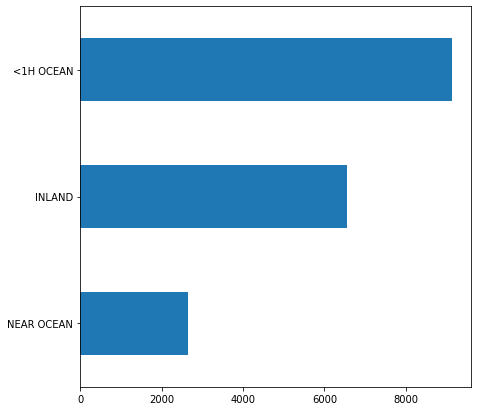

In [28]:
# Bar plot
(housing_categorical["ocean_proximity"]
 .value_counts(dropna=False)
 .nlargest(n=3)
 # Horitizon
 .plot(kind="barh")
 .invert_yaxis())

Most machine learning algorithms work well with numbers, so we need to convert these categories from text to numbers. We can use the `OrdinalEncoder` class, which encodes a categorical feature or variable as an integer array. The input to this `transformer` should be an array-like of integers or strings, denoting the values taken on by the categorical (discrete) variable. The features are converted to *ordinal* integers. This results in a single column of integers (0 to `n_categories - 1`) per feature or variable.

In [43]:
# Import class from the preprocessing module
from sklearn.preprocessing import OrdinalEncoder
# Instantiate an object of class OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# Call fit and transform methods 
housing_cat_encoded = ordinal_encoder.fit_transform(X=housing_categorical)

In [44]:
# Number of elements is the number of rows in the training set
len(housing_cat_encoded)

16512

In [45]:
# Each element is in and of itself an array containing 1 value, since there is only one text attribute in our training set
housing_cat_encoded[0:5]

array([[4.],
       [4.],
       [3.],
       [1.],
       [3.]])

We can get the list of categories using the instance attribute. The categories are stored in a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [46]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation--- a factor with multiple levels--- is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for our case. For example, categories 0 ('<1H OCEAN') and 4 ('NEAR OCEAN') are clearly more similar than categories 0 ('<1H OCEAN') and 1 ('INLAND'). To address this potential problem, we create five binary indicator variables using 0 and 1 encoding. Fortunately, `Scikit-Learn` provides a
`OneHotEncoder` class to convert categorical values into 0-1 vectors. The input to this `transformer` should again be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a `one-hot` (aka ‘one-of-K’ or ‘dummy’) encoding scheme. This creates a binary column for each category (factor level) and returns a sparse matrix or dense array (depending on the sparse parameter). By default, the encoder derives the categories (levels) based on the unique values in each feature. Alternatively, we can also specify the categories manually using the `categories` parameter:

In [29]:
# Import class from the preprocessing module
from sklearn.preprocessing import OneHotEncoder
# Instantiate object of class OneHotEncoder
cat_encoder = OneHotEncoder()
# Call fit and transform
housing_cat_dummy = cat_encoder.fit_transform(X=housing_categorical)
housing_cat_dummy

<20640x10 sparse matrix of type '<class 'numpy.float64'>'
	with 41280 stored elements in Compressed Sparse Row format>

The returned object is a *sparse* matrix, which is very useful when we have categorical attributes with thousands of categories. After dummy encoding, we usually get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful; instead, *a sparse matrix only stores the location of the nonzero elements*. However, we can convert it into a dense array by calling the `toarray()` method, which returns a dense `ndarray` representation of this matrix:

In [48]:
# Dense ndarray
housing_cat_dummy.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [49]:
# The number of elements in the array is the number of rows in the training set
len(housing_cat_dummy.toarray())

16512

In [50]:
# Each element is in and of itself an array containing 5 values, one for each category or level of the attribute 'ocean_proximity'
# The array below can be consider as the 2nd trial or instance or row of the training set
housing_cat_dummy.toarray()[1]

array([0., 0., 0., 0., 1.])

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then this allocation code will result in a large number of input features or variables. This may slow down training and degrade performance. In those instances, we may want to replace the categorical input with useful numerical features related to the categories. Alternatively, we could also replace each category with a learnable, low-dimensional vector called an **embedding**. Each category’s representation would be learned during training. This is an example of **representation learning**.

### Data Transformation <a class="anchor" id="data-transformation"></a>



Since the labels or response variable is right skewed, we may explore a Box-Cox transformation on this variable:

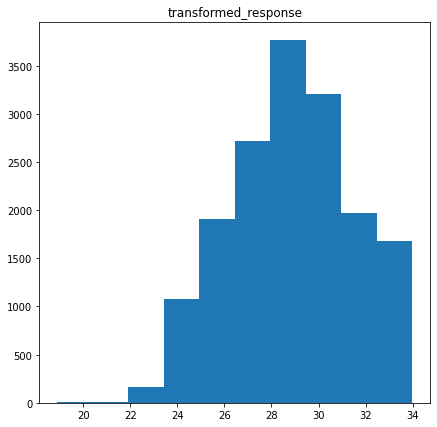

In [51]:
# Import module
from scipy import stats
# Figure size
plt.rcParams['figure.figsize'] = [7, 7]
# This returns a Box-Cox power transformed array
pd.DataFrame(stats.boxcox(housing_labels.array)[0], columns=["transformed_response"]).hist()
plt.grid(False)
plt.show()

If we transform the response by taking the natural logrithms of the label values:

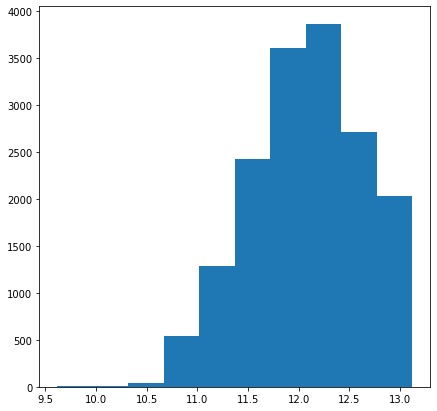

In [52]:
# Import 
import math
# Transformation
housing_labels.apply(lambda x: math.log(x)).hist()
plt.grid(False)
plt.show()

We may also experiment with different combinations of the predictor variables or attributes. For example, the total number of rooms is not very useful if we don’t know the number of households in a district. What we need is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful; therefore, we need to compare it to the number of rooms. Lastly, population per household may also be a more interesting attribute to examine compared to population alone. We create these new attributes as follows:

In [53]:
# New attributes
housing_features["rooms_per_household"] = housing_features["total_rooms"] / housing_features["households"]
housing_features["bedrooms_per_room"] = housing_features["total_bedrooms"] / housing_features["total_rooms"]
housing_features["population_per_household"] = housing_features["population"] / housing_features["households"]
# New data frame
housing_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,NEAR OCEAN,4.620968,0.231530,3.881720
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,NEAR OCEAN,5.745981,0.174035,3.562701
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,NEAR BAY,8.518248,0.317052,1.846715
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,INLAND,6.081690,0.170912,3.214085
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,NEAR BAY,7.225146,0.141238,2.576023
...,...,...,...,...,...,...,...,...,...,...,...,...
8285,-118.14,33.77,51.0,2812.0,621.0,1171.0,566.0,3.8750,NEAR OCEAN,4.968198,0.220839,2.068905
20569,-121.76,38.66,17.0,5320.0,984.0,2866.0,928.0,4.1997,INLAND,5.732759,0.184962,3.088362
12632,-121.48,38.49,26.0,3165.0,806.0,2447.0,752.0,1.5908,INLAND,4.208777,0.254660,3.253989
5135,-118.26,33.97,46.0,1521.0,352.0,1100.0,334.0,1.5500,<1H OCEAN,4.553892,0.231427,3.293413


Let us examine the correlations of these new attributes with the response variable: 

In [54]:
# Correlation matrix
corr_matrix = pd.concat([housing_features, housing_labels], axis=1, copy=True).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686289
rooms_per_household         0.147401
total_rooms                 0.135723
housing_median_age          0.109030
households                  0.066404
total_bedrooms              0.050819
population_per_household   -0.021876
population                 -0.024405
longitude                  -0.045513
latitude                   -0.145896
bedrooms_per_room          -0.253819
Name: median_house_value, dtype: float64

Both `rooms_per_household`, `bedrooms_per_room` are weakly correlated with median housing value. However, while the number of rooms per household is positively correlated with housing value, the number of bedrooms per room is negatively correlated with the response.

In [57]:
# Revert data back to training set 
housing_features = strat_train_set.drop("median_house_value", axis=1)
housing_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,NEAR OCEAN
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,NEAR OCEAN
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,NEAR BAY
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,INLAND
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,NEAR BAY
...,...,...,...,...,...,...,...,...,...
8285,-118.14,33.77,51.0,2812.0,621.0,1171.0,566.0,3.8750,NEAR OCEAN
20569,-121.76,38.66,17.0,5320.0,984.0,2866.0,928.0,4.1997,INLAND
12632,-121.48,38.49,26.0,3165.0,806.0,2447.0,752.0,1.5908,INLAND
5135,-118.26,33.97,46.0,1521.0,352.0,1100.0,334.0,1.5500,<1H OCEAN


Serialize training set and test set to disk:

In [77]:
# Training set
housing_features.to_pickle(path="dataset/training_X.pkl")
housing_labels.to_pickle(path="dataset/training_y.pkl")
# Test set
strat_test_set.drop("median_house_value", axis=1).to_pickle(path="dataset/test_X.pkl")
strat_test_set["median_house_value"].to_pickle(path="dataset/test_y.pkl")

### Custom Transformer <a class="anchor" id="custom-transformer"></a>

First, we load the pickle files from disk containing the training set features and lables:

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
# Set working directory
os.chdir(os.getcwd().replace("/jupyter_notebooks", ""))
# Load in training set 
housing_features = pd.read_pickle("dataset/training_X.pkl")
housing_labels = pd.read_pickle("dataset/training_y.pkl")
# Create a data frame with numerical data only
housing_numerical_features = housing_features.drop(
    labels=["ocean_proximity"],
    axis=1,
    inplace=False
)  

To allow for seemlessly working with the Scikit-Learn API, espeically the pipeline, we may want to create a custom transofmer that adds the combined attributes in the data transformation section above. 

In [2]:
# Import base classes from which custom transformer inherits
from sklearn.base import BaseEstimator, TransformerMixin


# Column names
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
# List comprehension and unpack to get column indexes, which are essentially the integer locations of these columns
rooms_id, bedrooms_id, population_id, households_id = [housing_features.columns.get_loc(col) for col in col_names] 


# Custom transformer
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # Constructor
    def __init__(self, add_bedrooms_per_room=True): 
        # Hyperparameter for controlling feature engineering
        # If true, then add the new attribute 'bedrooms_per_room'
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        # Create new attributes
        rooms_per_household = X[:, rooms_id] / X[:, households_id]
        population_per_household = X[:, population_id] / X[:, households_id]
        # If the hyperparameter self.add_bedrooms_per_room = True
        if self.add_bedrooms_per_room:
            # Create this attribute
            bedrooms_per_room = X[:, bedrooms_id] / X[:, rooms_id]
            # Include these additional attributes in the transformed feature matrix
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In this example the transformer has one hyperparameter, `add_bedrooms_per_room` , set to `True` by default. This hyperparameter will allow us to easily find out whether adding this attribute helps the Machine Learning algorithms or not. In general, we can add a hyperparameter to gate any data preparation step that we are not 100% sure about. This `True` and `False` options allows us to easily automate experimenting with data preparation or transformation steps. 

### Transformation Pipeline <a class="anchor" id="transformation-pipeline"></a>

Data wrangling and cleaning involves various steps. The Scikit-Learn package provides the `pipeline` class to support the need to perform sequences of transformations on a dataset. This class sequentially applies a `list` of transformations and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement `fit` and `transform` methods. The final estimator only needs to implement `fit`, which returns `self`. The transformers in the pipeline can be cached using the `memory` argument; caching the transformers is advantageous when the fitting processes are time consuming. The constructor takes the following arguments:

* steps: list of tuple. This is a list of (name, transform) tuples (implementing fit/transform) that are chained, in the order in which they are chained, with the last object an estimator.
* memory: str or object with the joblib. Memory interface, default=None
* verbose: bool, default=False. If True, the time elapsed while fitting each step will be printed as it is completed.

In [3]:
# Import classes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# Pipeline for preprocessing the numerical attributes
numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attr_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
        ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))
    ])
# Call fit and transform on pipeline
housing_numerical_training = numerical_pipeline.fit_transform(housing_numerical_features)
# Convert to data frame
pd.DataFrame(
    data=housing_numerical_training,
    columns=housing_numerical_features.columns.tolist() + ["rooms_per_household", "popuplation_per_household", "bedrooms_per_room"]
)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,popuplation_per_household,bedrooms_per_room
0,0.681390,-0.851695,0.422099,-0.422593,-0.331879,0.023297,-0.334438,-0.539136,-0.313992,0.067328,0.263824
1,1.151279,-1.221935,-0.294522,-0.390923,-0.542606,-0.287148,-0.496586,0.060388,0.120078,0.039823,-0.598688
2,-1.253155,0.957327,-0.214898,-0.679683,-0.399699,-1.077121,-0.959108,-0.762457,1.189716,-0.108120,1.546782
3,-0.938229,1.435359,-0.374147,-0.217666,-0.402121,-0.256658,-0.379627,0.061809,0.249606,0.009768,-0.645526
4,-1.263152,0.821416,0.501723,-0.072354,-0.450564,-0.496883,-0.414183,1.976831,0.690792,-0.045243,-1.090680
...,...,...,...,...,...,...,...,...,...,...,...
16507,0.716381,-0.875128,1.775716,0.086465,0.208261,-0.228940,0.181247,0.003741,-0.180018,-0.088964,0.103448
16508,-1.093192,1.416612,-0.931518,1.254549,1.087501,1.337146,1.143505,0.174680,0.114976,-0.001072,-0.434756
16509,-0.953225,1.336940,-0.214898,0.250872,0.656358,0.950014,0.675667,-1.198780,-0.473029,0.013208,0.610813
16510,0.656395,-0.781396,1.377593,-0.514810,-0.443298,-0.294540,-0.435448,-1.220259,-0.339872,0.016607,0.262275


The constructor `Pipeline` takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything as long as they are unique and don’t contain double underscores; these names will be useful later for hyperparameter tuning. When we call the pipeline’s `fit_transform()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method and returns the transformed data via `self`.

The standardization uses the follow formulat: $z=\frac{x-\mu}{\sigma}$. Note that $\mu$ is the mean of the training samples or zero if `with_mean=False`; $\sigma$ is the standard deviation of the training samples or one if `with_std=False`. 

Since 0.20, Scikit-Learn has introduced the `ColumnTransformer` class to allow for different columns or column subsets of the input to be transformed separately; the features generated by each transformer will be concatenated to form a single feature space. The `ColumnTransformer` helps with performing different transformations for different columns of the data within a `Pipeline` that is safe from data leakage and that can be parametrized. The class constructor has the following **important** arguments:

* transformers : This is a list of (name, transformer, columns) tuples specifying the transformer objects to be applied to subsets of the data.
    - name : str.
    - transformer : $\{'drop', 'passthrough' \}$ or estimator. Estimator must support `fit` and `transform`. Special-cased
    strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through
    untransformed, respectively.
    - columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable. Indexes the data on
    its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. 
    To select multiple columns by name or dtype, we can use `make_column_selector`.
* remainder : $\{'drop', 'passthrough' \}$ or estimator, default='drop'
    - By default, only the specified columns in transformers are transformed and combined in the output, and the non
    specified columns are dropped. (default of 'drop' ). By specifying remainder=' passthrough', all remaining columns that
    were not specified in transformers will be automatically passed through. This subset of columns is concatenated with the
    output of the transformers. By setting remainder to be an estimator, the remaining non-specified columns will use the
    remainder estimator. The estimator must support fit and transform. Note that using this feature requires that the
    DataFrame columns input at fit and transform have identical order.

The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. Columns of the original feature matrix that are not specified are dropped from the resulting transformed feature matrix, unless specified in the passthrough keyword. Those columns specified with passthrough are added to the right of the output of the transformers:

In [4]:
# Import
import joblib
from sklearn.compose import ColumnTransformer

# Select columns
# Wrapping a data frame object in a list() function returns a list of column names
numerical_attributes = list(housing_features.select_dtypes(include=np.number))
categorical_attributes = list(housing_features.select_dtypes(include=object))

# Pipeline
pipeline = ColumnTransformer(
    transformers=[
        ("numerical", numerical_pipeline, numerical_attributes),
        ("categorical", OneHotEncoder(), categorical_attributes),
    ],
    remainder='drop'
)

# Serialize the pipeline
joblib.dump(pipeline, "processing/pipeline.pkl")

# Transformation
housing_prepared = pipeline.fit_transform(housing_features)
housing_prepared

array([[ 0.68138959, -0.85169496,  0.42209878, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.15127891, -1.22193521, -0.29452206, ...,  0.        ,
         0.        ,  1.        ],
       [-1.25315474,  0.95732705, -0.21489752, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.95322539,  1.33694048, -0.21489752, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65639548, -0.78139617,  1.37759324, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56141785,  0.75580388, -0.69264475, ...,  0.        ,
         0.        ,  0.        ]])

In [6]:
# Examine the shape
housing_prepared.shape

(16512, 16)

Note that the `OneHotEncoder` returns a sparse matrix, while the `numerical_pipline` returns a dense matrix. When there is such a mix of sparse and dense matrices, the `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, `sparse_threshold=0.3`). Finally, we serialize the object `housing_prepared`:

In [70]:
# Using np.save
# Open file for writing in binary mode
with open('dataset/prepared_data.npz', 'wb') as f:
    np.savez(
        file=f,
        features=housing_prepared
    )

## Model <a class="anchor" id="model"></a>

### Mutiple Linear Regression <a class="anchor" id="multiple-linear-regression"></a>

The first model we will train is the multiple linear regression model:

In [ ]:
# Open file for reading in binary mode
with open('dataset/prepared_data.npz', 'rb') as f:
    data_file = np.load(f)
    housing_prepared, data_file['features']
# Import regression class from module
from sklearn.linear_model import LinearRegression
# Class constructor 
lin_reg = LinearRegression(fit_intercept = True, copy_X = True, n_jobs = None, positive = False)
# Fit 
lin_reg.fit(X=housing_prepared, y=housing_labels)
# Retreive attributes of the class
lin_reg.intercept_, lin_reg.coef_

We can store our model as a pickle file to disk:

In [30]:
os.getcwd()

'/Users/kenwu/Desktop/Python/Python for Machine Learning/California housing price project'

In [32]:
# Models can be loaded with joblib.load('models/linear_regression.pkl')
joblib.dump(lin_reg, 'models/linear_regression.pkl')

['models/linear_regression.pkl']

We can use the `stargazer` package to output the regression results. This requires that we use the `statsmodels.regression.linear_model.OLS` class from the `statsmodels` module rather than the `LinearRegression` class from Sklearn:

In [9]:
# Import
import statsmodels.api as sm
# Add intercept term
X = sm.add_constant(housing_prepared)
# Model
model = sm.OLS(housing_labels, X)
# Fit
results = model.fit()
results.params

const    201494.226248
x1       -55760.498578
x2       -57028.092545
x3        13219.586068
x4          554.665389
x5         7185.389796
x6       -51604.681034
x7        49014.292369
x8        73809.813898
x9         6088.334958
x10        1810.158813
x11        8917.973756
x12       17180.171517
x13      -20125.604515
x14      168189.803379
x15       12797.431689
x16       23452.424177
dtype: float64

Now, we can render the regression out as a hmtl table:

In [10]:
# Import class from stargazer module
from stargazer.stargazer import Stargazer
# Instantiate a Stargzer class object
stargazer = Stargazer([results])

Next, we can call the `render_html()` method on the `Stargazer` class object, which returns the html code. The html code can be directly rendered in a markdown cell as follows:

<table style="text-align:center"><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="1"><em>Dependent variable:median_house_value</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td></tr><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">const</td><td>201494.226<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(5103.998)</td></tr><tr><td style="text-align:left">x1</td><td>-55760.499<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(2264.637)</td></tr><tr><td style="text-align:left">x10</td><td>1810.159<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(551.227)</td></tr><tr><td style="text-align:left">x11</td><td>8917.974<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(764.852)</td></tr><tr><td style="text-align:left">x12</td><td>17180.172<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(5147.678)</td></tr><tr><td style="text-align:left">x13</td><td>-20125.605<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(5325.933)</td></tr><tr><td style="text-align:left">x14</td><td>168189.803<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(25403.184)</td></tr><tr><td style="text-align:left">x15</td><td>12797.432<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(5327.727)</td></tr><tr><td style="text-align:left">x16</td><td>23452.424<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(5253.419)</td></tr><tr><td style="text-align:left">x2</td><td>-57028.093<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(2389.802)</td></tr><tr><td style="text-align:left">x3</td><td>13219.586<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(610.817)</td></tr><tr><td style="text-align:left">x4</td><td>554.665<sup></sup></td></tr><tr><td style="text-align:left"></td><td>(2112.353)</td></tr><tr><td style="text-align:left">x5</td><td>7185.390<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(3079.455)</td></tr><tr><td style="text-align:left">x6</td><td>-51604.681<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(1441.494)</td></tr><tr><td style="text-align:left">x7</td><td>49014.292<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(3093.792)</td></tr><tr><td style="text-align:left">x8</td><td>73809.814<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(744.333)</td></tr><tr><td style="text-align:left">x9</td><td>6088.335<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(670.049)</td></tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>16,512</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.653</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.652</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>68059.696 (df=16496)</td></tr><tr><td style="text-align: left">F Statistic</td><td>2065.545<sup>***</sup> (df=15; 16496)</td></tr><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td> <td colspan="1" style="text-align: right">  <sup>*</sup>p&lt;0.1;  <sup>**</sup>p&lt;0.05;  <sup>***</sup>p&lt;0.01 </td></tr></table>

Next, we can make some predictions using a random sample of instances or trials from the training set:

In [12]:
# Import random module
import random as rd
# First 3 rows and 2 random rows of the training set
five_instances = housing_features.iloc[:3, :].append(housing_features.iloc[3:, :].sample(n=2))
# Obtain associating labels of these instances
five_lables = housing_labels[five_instances.index]
# Apply transformation pipeline
five_ins_prepared = pipeline.transform(five_instances)
# Predictions by calling the predict method 
print("Predictions:", lin_reg.predict(five_ins_prepared))

Predictions: [181658.43307811 212825.92433789 196623.32365586 318565.01007782
 114489.88315386]


In [13]:
# Compared to the labels
print("Labels:", list(five_lables))

Labels: [139300.0, 215800.0, 275000.0, 240900.0, 103000.0]


In [15]:
# Import function from metrics module
from sklearn.metrics import mean_squared_error
# Predictions
housing_predictions_linear = lin_reg.predict(housing_prepared)
# Obtain MSE and RMSE
MSE_linear, RMSE_linear = mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_linear, squared=True), mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_linear, squared=False)
# Show output
f'MSE={MSE_linear} and RMSE={RMSE_linear}'

'MSE=4627633791.525345 and RMSE=68026.71380807208'

Note that this MSE estimator is slightly different from that of the `statsmodel` output, which is 68059.696 in the `stargazer` output above. We may also obtain the mean absoluate error:

In [16]:
# Import function 
from sklearn.metrics import mean_absolute_error
# MAE
mean_absolute_error(housing_labels, housing_predictions_linear)

49420.38667984563

If we carry out the Box-Cox procedure on the reponse variable, which indicates we need to take the natural log of the reponse:

In [17]:
# Import stats module
from scipy import stats
# New model using transformed response
lin_reg_transformed = LinearRegression(fit_intercept = True, copy_X = True, n_jobs = None, positive = False)
# Fit 
lin_reg_transformed.fit(X=housing_prepared, y=stats.boxcox(housing_labels.array)[0])

LinearRegression()

Next, we can make some predictions using the new model and back-transform to obtain the estimated mean responses in the original units:

In [18]:
# Import inverse box cox function from the special module
from scipy import special
# Predictions
housing_predictions_linear_transformed = special.inv_boxcox(
    lin_reg_transformed.predict(housing_prepared),
    stats.boxcox(housing_labels.array)[1]
)
# Obtain MSE and RMSE
MSE_linear_trn, RMSE_linear_trn = (
    mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_linear_transformed, squared=True),
    mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_linear_transformed, squared=False)
)
# Show output
f'MSE={MSE_linear_trn} and RMSE={RMSE_linear_trn}'

'MSE=6110974097.475562 and RMSE=78172.71964998763'

The transformed response, in fact, does not improve prediction.

### Decision Trees <a class="anchor" id="decision-trees"></a>

The next learning algorithm we use is a regression tree. The Sklearn package has `DecisionTreeRegressor` class that builds regressioin trees:

In [20]:
# Import class from tree module
from sklearn.tree import DecisionTreeRegressor
# Instantiate object with specified parameters
reg_tree = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=17,
    max_leaf_nodes=None,
    ccp_alpha=0.0
)
# Build regression tree using recursive binary splitting
reg_tree.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=17)

In [33]:
# Store model to disk
joblib.dump(reg_tree, "models/regression_tree.pkl")

['regression_tree.pkl']

In [21]:
# Predictions on training set
housing_predictions_reg_tree = reg_tree.predict(housing_prepared)
# MSE
mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_reg_tree, squared=False)

0.0

The `DecisionTreeRegressor` class constructor has the following parameters, many of which are regularization parameters that safeguards against atrocious overfitting:

* **criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}, default=”squared_error”**. The function to measure the quality of a split. Supported criteria are “squared_error” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, “absolute_error” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node, and “poisson” which uses reduction in Poisson deviance to find splits.

* **splitter{“best”, “random”}, default=”best”**. The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split at each node.

* **max_depth**, int, default=None. The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than **min_samples_split** samples.

* **min_samples_split, int or float, default=2**. The minimum number of samples required to split an internal node:

    - If int, then consider **min_samples_split** as the minimum number.

    - If float, then **min_samples_split** is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split. The Python number method `ceil(x)` returns ceiling value of x - the smallest integer not less than x.

* **min_samples_leaf, int or float, default=1**. The minimum number of samples required to be at a leaf node. A split at any depth (or internal node) will only be considered if it leaves at least **min_samples_leaf** training samples in each of the left and right branches (or regions). This may have the effect of smoothing the model, especially in regression.

    - If int, then consider **min_samples_leaf** as the minimum number.

    - If float, then **min_samples_leaf** is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node.

* **min_weight_fraction_leaf, float, default=0.0**. The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

* **max_features, int, float or {“auto”, “sqrt”, “log2”}, default=None**. The number of features to consider when looking for the best split:

    - If int, then consider **max_features** number of features at each split.

    - If float, then **max_features** is a fraction and `int(max_features * n_features)` features are considered at each split. The `int()` method returns an integer object from any number (no roudning and simply return the number before the decimal) or string.

    - If “auto”, then max_features=n_features.

    - If “sqrt”, then max_features=sqrt(n_features).

    - If “log2”, then max_features=log2(n_features).

    - If None, then max_features=n_features.

* **random_state, int, RandomState instance or None, default=None** Controls the randomness of the estimator. The features are always randomly permuted at each split, even if splitter is set to "best". 

    - When max_features < n_features, the algorithm will select max_features number of features at random at each split before finding the best split among them. But the best found split may vary across different runs, even if max_features=n_features. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random. To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer. 

* **max_leaf_nodes, int, default=None**. Grow a tree with **max_leaf_nodes** in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

* **min_impurity_decrease, float, default=0.0**. A node will be split if this split induces a decrease of the impurity greater than or equal to this threshold.

    - The weighted impurity decrease equation is: `N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)`
    
    - N is the total number of samples
    
    - N_t is the number of samples at the current node
    
    - N_t_L is the number of samples in the left child or region
    
    - N_t_R is the number of samples in the right child or region
 
 * **ccp_alpha, non-negative float, default=0.0**. Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

### Random Forest <a class="anchor" id="random-forest"></a>

In [22]:
# Import class from ensemble module
from sklearn.ensemble import RandomForestRegressor
# Instantiate with specified parameters
forest_reg = RandomForestRegressor(
    n_estimators=100, 
    criterion='squared_error', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=17, 
    verbose=0, 
    warm_start=False, 
    ccp_alpha=0.0, 
    max_samples=None
)
# Build random forest
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=17)

In [34]:
# Pickle the model
joblib.dump(forest_reg, "models/random_forest.pkl")

['random_forest.pkl']

In [23]:
# Predictions on training set
housing_predictions_forest_reg = forest_reg.predict(housing_prepared)
# MSE
mean_squared_error(y_true=housing_labels, y_pred=housing_predictions_forest_reg, squared=False)

18651.83092453502

As can be seen, the RMSE of the random forest regression is much lower thatn that of the linear regression model. Although the RMSE of the regression tree is still lower at 0, it likely overfit the training set compared to the random forest regression. The MAE of the random forest regression can be computed as follows:

In [24]:
# MAE
mean_absolute_error(housing_labels, housing_predictions_forest_reg)

12064.18097141473

The class constructor for the `RandomForestRegressor` class has the following parameters:

* **n_estimators, int, default=100**. The number of trees in the forest.

* **criterion{“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”**. The function to measure the quality of a split. Training using “absolute_error” is significantly slower than when using “squared_error”.

* **max_depth, int, default=None**. The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than **min_samples_split** samples.

* **min_samples_split, int or float, default=2**. The minimum number of samples required to split an internal node:

    - If int, then consider **min_samples_split** as the minimum number.

    - If float, then **min_samples_split** is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.

* **min_samples_leaf, int or float, default=1**. The minimum number of samples required to be at a leaf node.

    - If int, then consider min_samples_leaf as the minimum number.

    - If float, then **min_samples_leaf** is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node.

* **min_weight_fraction_leaf, float, default=0.0**. The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when **sample_weight** is not provided.

* **max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”**. The number of features to consider when looking for the best split. These are the same as the `DecisionTreeRegressor` class.

* **max_leaf_nodes, int, default=None**. Grow trees with **max_leaf_nodes** in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

* **min_impurity_decreasefloat, default=0.0**. A node will be split if this split induces a decrease of the impurity greater than or equal to this threshold.

    - The weighted impurity decrease equation is: `N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)`
    
    - N is the total number of samples
    
    - N_t is the number of samples at the current node
    
    - N_t_L is the number of samples in the left child or region
    
    - N_t_R is the number of samples in the right child or region

* **bootstrap, bool, default=True**. Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

* **oob_score, bool, default=False**. Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.

* **n_jobs, int, default=None**. The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

* **random_state, int, RandomState instance or None, default=None**. Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).

* **verbose, int, default=0**. Controls the verbosity when fitting and predicting.

* **warm_start, bool, default=False**. When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.

* **ccp_alphanon-negative float, default=0.0**

* **max_samples, int or float, default=None**

    - If bootstrap is True, then **max_samples** is the number of samples to draw from X to train each base estimator.

    - If None (default), then draw **X.shape[0]** samples, which equals the number of rows in the training set.

    - If int, then draw **max_samples** samples.

    - If float, then draw **max_samples * X.shape[0](number of rows in the training set)** samples. Thus, **max_samples** should be in the interval (0.0, 1.0].

### Support Vector Machine <a class="anchor" id="support-vector-machine"></a>

In [37]:
# Import class
from sklearn.svm import SVR
# Instantiate
svm_reg = SVR(kernel="linear")
# Fit classifier to data
svm_reg.fit(housing_prepared, housing_labels)
# Make prediction
housing_predictions_svm = svm_reg.predict(housing_prepared)
# Evaluation
svm_mse = mean_squared_error(housing_labels, housing_predictions_svm)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

110675.39205134124

In [46]:
# Store to disk
joblib.dump(svm_reg, "models/svm.pkl")

['models/svm.pkl']

In [45]:
# Examine attributes of model
svm_reg.__dir__()

['kernel',
 'degree',
 'gamma',
 'coef0',
 'tol',
 'C',
 'nu',
 'epsilon',
 'shrinking',
 'probability',
 'cache_size',
 'class_weight',
 'verbose',
 'max_iter',
 'random_state',
 '_sparse',
 'n_features_in_',
 'class_weight_',
 '_gamma',
 'support_',
 'support_vectors_',
 '_n_support',
 'dual_coef_',
 'intercept_',
 '_probA',
 '_probB',
 'fit_status_',
 'shape_fit_',
 '_intercept_',
 '_dual_coef_',
 '__module__',
 '__doc__',
 '_impl',
 '__init__',
 '_more_tags',
 '__abstractmethods__',
 '_abc_impl',
 '_estimator_type',
 'score',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 '_sparse_kernels',
 '_pairwise',
 'fit',
 '_validate_targets',
 '_warn_from_fit_status',
 '_dense_fit',
 '_sparse_fit',
 'predict',
 

### Model Tuning  <a class="anchor" id="model-tuning"></a>

The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem. Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data. In sklearn, hyper-parameters are parameters that are not directly learnt within estimators. They are typically passed as arguments to the constructor of the estimator classes `LinearRegression`, `RandomForestRegressor`, or `SVR`. How do we know which set or combination of hyper-parameters result in the best model performance? The recommended approach is to search the hyper-parameter space for the best cross validation score or model performance. Two generic approaches to parameter search are provided in scikit-learn:

* `GridSearchCV` exhaustively considers all parameter combinations.
* `RandomizedSearchCV` samplea a given number of candidates from a parameter space with a specified distribution.

Both these tools have successive halving counterparts `HalvingGridSearchCV` and `HalvingRandomSearchCV`, which can be much faster at finding a good parameter combination. 

### Exhaustive Grid Search  <a class="anchor" id="exhaustive-grid-search"></a>

The grid search provided by `GridSearchCV` exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter. Below, the grid search will explore 12 + 6 = 18 combinations of hyperparameter values for the `RandomForestRegressor` estimator, and it will train each model 5
times (since we are using five-fold cross validation). There will be 18 × 5 = 90 rounds of training or experiments.


In [58]:
# Import class
from sklearn.model_selection import GridSearchCV

# Grid of parameter values
# List of dictionaries
param_grid = [
    # Try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8]},
    # Try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [30, 50, 100], 'max_features': [2, 3, 4]},
]

# Instantiate
forest_reg = RandomForestRegressor(random_state=17)
# Train across 5 folds,  a total of (12 + 6) * 5 = 90 rounds of training 
grid_search_rf = GridSearchCV(
    estimator=forest_reg, 
    param_grid=param_grid, 
    # Determines the cross-validation splitting strategy
    cv=5,
    # Strategy to evaluate the performance of the cross-validated model on test set
    scoring='neg_mean_squared_error',
    return_train_score=True
)
# Call fit on estimator
grid_search_rf.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=17),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 50, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [30, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
# Store grid search object to disk
joblib.dump(grid_search_rf, "tuning/gs_random_forest.pkl")

['tuning/gs_random_forest.pkl']

The best hyperparameter combination is stored as an attribute of the object:

In [60]:
# Obtain optimized hyperparameter combination
grid_search_rf.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 100}

In [61]:
# The estimator that gave highest score on the training set
grid_search_rf.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, random_state=17)

The `cv_results_` attributes contains a dictionary of `numpy` (masked) ndarrays with keys as column headers and values as columns; this attribute can be passed to the `pd.DataFrame` constructor:

In [62]:
# The cross validation results
pd.DataFrame(grid_search_rf.cv_results_).iloc[:, 4:]

,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.848139e+09,-4.225661e+09,-3.867325e+09,-4.286468e+09,-3.913892e+09,-4.028297e+09,1.881820e+08,29,-1.106464e+09,-1.133811e+09,-1.059605e+09,-1.106007e+09,-1.131058e+09,-1.107389e+09,2.662500e+07
1,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.831407e+09,-2.974218e+09,-2.944506e+09,-3.211027e+09,-3.114781e+09,-3.015188e+09,1.332080e+08,25,-5.798375e+08,-5.724182e+08,-5.666050e+08,-5.572066e+08,-5.825347e+08,-5.717204e+08,9.166680e+06
2,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.671586e+09,-2.739323e+09,-2.750407e+09,-3.060879e+09,-2.819966e+09,-2.808432e+09,1.347089e+08,23,-4.373589e+08,-4.341818e+08,-4.331800e+08,-4.252457e+08,-4.313132e+08,-4.322559e+08,4.015832e+06
3,2,50,NaN,"{'max_features': 2, 'n_estimators': 50}",-2.619745e+09,-2.680011e+09,-2.694956e+09,-2.975671e+09,-2.765472e+09,-2.747171e+09,1.233058e+08,20,-4.030959e+08,-4.001551e+08,-4.056627e+08,-3.987444e+08,-4.024493e+08,-4.020215e+08,2.400767e+06
4,2,100,NaN,"{'max_features': 2, 'n_estimators': 100}",-2.552603e+09,-2.620377e+09,-2.625766e+09,-2.927887e+09,-2.683472e+09,-2.682021e+09,1.297427e+08,18,-3.838918e+08,-3.763715e+08,-3.754957e+08,-3.730876e+08,-3.810551e+08,-3.779803e+08,3.926827e+06
5,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.533006e+09,-3.588968e+09,-3.756926e+09,-3.897690e+09,-3.562242e+09,-3.667766e+09,1.387941e+08,28,-9.690623e+08,-9.160630e+08,-9.474796e+08,-9.425265e+08,-9.491431e+08,-9.448549e+08,1.700395e+07
6,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.647027e+09,-2.875191e+09,-2.711261e+09,-3.071923e+09,-2.800581e+09,-2.821197e+09,1.473940e+08,24,-5.467458e+08,-5.182331e+08,-5.102135e+08,-5.153834e+08,-5.206181e+08,-5.222388e+08,1.273473e+07
7,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.428912e+09,-2.579610e+09,-2.478019e+09,-2.811264e+09,-2.563635e+09,-2.572288e+09,1.316674e+08,15,-4.086309e+08,-3.925906e+08,-3.936952e+08,-3.882821e+08,-3.893702e+08,-3.945138e+08,7.334204e+06
8,4,50,NaN,"{'max_features': 4, 'n_estimators': 50}",-2.354620e+09,-2.489515e+09,-2.438902e+09,-2.761525e+09,-2.519493e+09,-2.512811e+09,1.363328e+08,12,-3.723877e+08,-3.592925e+08,-3.644647e+08,-3.595477e+08,-3.649710e+08,-3.641327e+08,4.762534e+06
9,4,100,NaN,"{'max_features': 4, 'n_estimators': 100}",-2.319073e+09,-2.446330e+09,-2.418535e+09,-2.689678e+09,-2.505361e+09,-2.475795e+09,1.227428e+08,7,-3.555716e+08,-3.447301e+08,-3.463076e+08,-3.375469e+08,-3.468767e+08,-3.462066e+08,5.750372e+06


As can be seen, the estimator `RandomForestRegressor(bootstrap=False, max_features=4, random_state=17)` has the largest `mean_test_score` -2.388360e+09.

In [81]:
pd.DataFrame(grid_search.cv_results_)['mean_test_score'].max()

-2382046097.8280697

Because the `scoring` argument is `neg_mean_squre_error`, the largest negative value means that the `mean_square_error` for this combination of hyper-parameters resulted in the lowest mean squre error.

### Randomized Grid Search  <a class="anchor" id="randomized-grid-search"></a>

The `RandomizedSearchCV` implements a randomized search over hypterparameters, where each specified setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

* A budget can be chosen independent of the number of parameters and possible values.

* Adding parameters that do not influence the performance does not decrease efficiency.

Simply put, a randomized grid search evaluates a given number of random hyperparameter combinations by selecting a random value for each hyperparameter at every iteration. 

* For 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few manually inputted values per hyperparameter with the grid search approach).

* Simply by setting the number of iterations, we have more control over the computing budget we wish want to allocate to the hyperparameter search.

Below, we conduct a randomized grid search to tune the hyperparameters of the `SVR` estimator.


In [ ]:
# Import 
# Exponential and reciprocal distribution, also known as the log-uniform distributions
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Grid
param_distribs = {
        # Try 'linear' and 'rbf' for the 'kernel' hyperparameter
        'kernel': ['linear', 'rbf'],
        # The 'C' regularization parameter expects a float that is randomly sampled from the reciprocal distribution
        'C': reciprocal(20, 200000),
        # Kernel coefficient for ‘rbf’ randomly sampled from the exponential distribution
        'gamma': expon(scale=1.0),
    }

# Instantiate
svm_reg = SVR()

# Randomized search
rnd_search_svm = RandomizedSearchCV(
    estimator=svm_reg, 
    param_distributions=param_distribs,
    n_iter=50, 
    cv=5, 
    scoring='neg_mean_squared_error',
    # Use verbose to track progress
    verbose=2, 
    random_state=17
)
# Call fit on estimator
rnd_search_svm.fit(housing_prepared, housing_labels)

In [88]:
# Store to disk
joblib.dump(rnd_search_svm, "tuning/rnd_search_svm.pkl")

['tuning/rnd_search_svm.pkl']

In [100]:
# The best combination of parameters
rnd_search_svm.best_params_

{'C': 143874.19765148754, 'gamma': 0.16519544952938497, 'kernel': 'rbf'}

In [101]:
# The best estimator
rnd_search_svm.best_estimator_

SVR(C=143874.19765148754, gamma=0.16519544952938497)

In [102]:
pd.DataFrame(rnd_search_svm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.713604,0.104239,0.750681,0.021281,301.779689,0.756272,linear,"{'C': 301.7796888426616, 'gamma': 0.7562717803...",-4.627317e+09,-4.867197e+09,-4.827977e+09,-5.468226e+09,-4.947404e+09,-4.947624e+09,2.808583e+08,21
1,34.940423,1.200255,3.780805,0.082425,71860.343431,1.64414,rbf,"{'C': 71860.3434310922, 'gamma': 1.64413976596...",-4.358439e+09,-4.409238e+09,-4.635899e+09,-4.883743e+09,-4.265870e+09,-4.510638e+09,2.228251e+08,6
2,7.043029,0.187308,3.911832,0.106126,8440.420483,1.014788,rbf,"{'C': 8440.420483318907, 'gamma': 1.0147884506...",-5.882519e+09,-5.963625e+09,-6.326322e+09,-6.449951e+09,-5.527587e+09,-6.030001e+09,3.294663e+08,35
3,6.182867,0.113092,0.788378,0.036770,6607.85415,1.965571,linear,"{'C': 6607.854150415167, 'gamma': 1.9655707223...",-4.532780e+09,-4.807393e+09,-4.701216e+09,-5.423780e+09,-4.990786e+09,-4.891191e+09,3.050055e+08,11
4,24.098968,2.380548,0.763547,0.021393,121272.615162,0.061923,linear,"{'C': 121272.6151618825, 'gamma': 0.0619229370...",-4.534343e+09,-4.807840e+09,-4.687406e+09,-5.422837e+09,-4.973116e+09,-4.885108e+09,3.049560e+08,7
5,6.421637,0.037200,3.547149,0.033309,27.433598,0.242726,rbf,"{'C': 27.43359796441616, 'gamma': 0.2427255518...",-1.250983e+10,-1.301763e+10,-1.352374e+10,-1.360908e+10,-1.193209e+10,-1.291848e+10,6.313580e+08,47
6,6.293814,0.051267,3.566989,0.018507,8141.500568,0.802407,rbf,"{'C': 8141.500568291713, 'gamma': 0.8024072197...",-5.302176e+09,-5.329451e+09,-5.665096e+09,-5.840307e+09,-4.983905e+09,-5.424187e+09,2.996340e+08,31
7,4.548299,0.046689,0.735935,0.009288,315.912141,0.474581,linear,"{'C': 315.91214088989466, 'gamma': 0.474580581...",-4.622483e+09,-4.864745e+09,-4.822019e+09,-5.469936e+09,-4.944892e+09,-4.944815e+09,2.832457e+08,20
8,6.242844,0.018582,3.628838,0.045253,310.407974,0.824416,rbf,"{'C': 310.40797374929, 'gamma': 0.824415775988...",-1.124841e+10,-1.172945e+10,-1.223527e+10,-1.225428e+10,-1.066050e+10,-1.162558e+10,6.085091e+08,45
9,6.362437,0.034983,3.616713,0.056517,30.680245,0.393175,rbf,"{'C': 30.680245052870156, 'gamma': 0.393175215...",-1.281823e+10,-1.334114e+10,-1.384539e+10,-1.392267e+10,-1.222908e+10,-1.323130e+10,6.390996e+08,48


Note: the reciprocal distribution is useful when we have no idea what the scale of the hyperparameter should be. As can be seen in the figure on the right, all scales are equally likely within the given range--- 20 and 200,000.

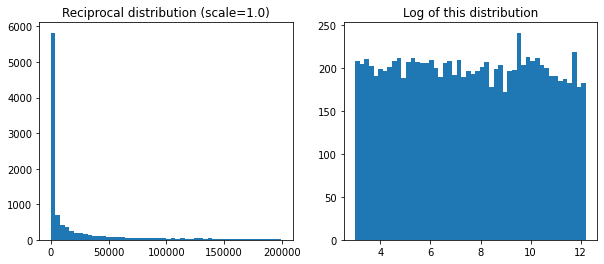

In [84]:
import matplotlib.pyplot as plt
# Instantiate reciprocal object
reciprocal_distrib = reciprocal(20, 200000)
# Generate a random numbers
samples = reciprocal_distrib.rvs(10000, random_state=17)
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

### Best Models Evaluation  <a class="anchor" id="best-models-evaluation"></a>

With the best estimators obtained from both the exhaustive and randomized grid searches, we now evaluate the two "best" models on the test set. First, we load in the two best models:

In [103]:
import joblib
# Load in models
svm_reg = joblib.load("tuning/rnd_search_svm.pkl").best_estimator_
rf_reg = joblib.load("tuning/gs_random_forest.pkl").best_estimator_

Next, we load in the test sets:

In [107]:
test_X = joblib.load('dataset/test_X.pkl')
test_y = joblib.load('dataset/test_y.pkl')

Then, the data processing pipeline:

In [113]:
pipeline = joblib.load('processing/pipeline.pkl')

Apply the pipeline to the test set and predict:

In [119]:
# Apply pipeline
test_X_prepared = pipeline.transform(test_X)
# Predictions
predictions_svm_reg = svm_reg.predict(test_X_prepared)
predictions_rf_reg = rf_reg.predict(test_X_prepared)
# Serialize predictions arrays
joblib.dump(predictions_svm_reg, "predictions/svm_reg_predictions.pkl")
joblib.dump(predictions_rf_reg, "predictions/rf_reg_predictions.pkl")

['predictions/rf_reg_predictions.pkl']

The mean square errors for these models are as follows:

In [136]:
mse_svm_reg = mean_squared_error(test_y, predictions_svm_reg)
mse_rf_reg = mean_squared_error(test_y, predictions_rf_reg)
f'MSE of Support Vector Regression = {mse_svm_reg}'

'MSE of Support Vector Regression = 2946634351.3482585'

In [137]:
f'MSE of Random Forest regressor = {mse_rf_reg}'

'MSE of Random Forest regressor = 2226195355.7351456'

As can be seen, the rnadom forerst regressor performed better than the support vector regression.

## Pycaret  <a class="anchor" id="pycaret"></a>